# MSE403 Lab 8: Tree based techniques
In this lab, feature engineering techniques will be performed to build and select the features for the ~7000 alloys found in the initial Magpie paper. Based on tree based techniques, including decision trees and random forest, a classification model will be made from the training data to predict the glass forming ability of the Cr, Ti, Co, Zr quaternary system.

#### Reference and Github copilot usage
The entire coding section of this lab report is written under the help of Github Copilot. The usage of large language model like ChatGPT will be marked.
A large section of code in this report is modified from MSE403 Practice 9. Any external reference will be marked.

## 1. Open the data, perform basic data preparation/cleaning

In [1]:
import scipy.io
import numpy.matlib as nm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import scipy
import re

For simplicity, the 'AC' (amorphous crystalline) in the original data is replaced with 'CR' (crystalline), to make it a binary classification problem instead of a multi-class one.

In [6]:
df_glass = pd.read_csv('glass.data',sep=' ')
#replace the column names
df_glass.columns = ['comp','gfa']
#in the gfa column, replace AC with CR
df_glass['gfa'] = df_glass['gfa'].replace('AC','CR')   #For simplicity, replace AC with CR
#drop NA
df_glass = df_glass.dropna()

To featurize the data, three featurizers are used: Miedema, Magpie ElementProperty, and WenAlloys. Element compositions are also added to the feature set. Then, all the features that are highly correlated are dropped, to get in total 159 informative features.

In [18]:
from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.composition import Miedema
from matminer.featurizers.composition import ElementProperty
from matminer.featurizers.composition import WenAlloys

In [20]:
X = pd.DataFrame({'formula':df_glass['comp']})
X = StrToComposition().featurize_dataframe(X, "formula")   #Featurization
X = Miedema().featurize_dataframe(X, col_id="composition")   #Featurization using Miedema featurizer

StrToComposition:   0%|          | 0/6836 [00:00<?, ?it/s]

Miedema:   0%|          | 0/6836 [00:00<?, ?it/s]

In [21]:
X = ElementProperty.from_preset("magpie").featurize_dataframe(X, col_id="composition")
X = WenAlloys().featurize_dataframe(X, col_id="composition")

ElementProperty:   0%|          | 0/6836 [00:00<?, ?it/s]

WenAlloys:   0%|          | 0/6836 [00:00<?, ?it/s]

In [23]:
X.to_csv('raw_matminer.csv',index=False)   #The feature set is saved to a .csv file for latter use

In [2]:
def drop_correlated_features(df, threshold):
    '''
    Define a function that drops features that are highly correlated with each other
    The threshold is the correlation value above which a feature is considered highly correlated.
    Return a list of the columns names that should be dropped
    '''
    #Generated by ChatGPT
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return to_drop

def add_polynomial_features(df,degree):
    '''
    Define a function that adds polynomial features to the dataframe
    For each feature in the dataframe, adding n-1 features that are the power of 2 to n of the original feature
    (n is the number of degrees)
    '''
    for column in df.columns:
        for i in range(2,degree+1):
            df[column+'^'+str(i)] = df[column]**i
    return df

In [3]:
def Element_Composition(X_comp):

    # Create a set of all the elements in the formulas
    elements = set()
    for formula in X_comp:
        elements.update(set(re.findall('[A-Z][a-z]*', formula)))

    # Create an empty dictionary to store the values for each formula
    formula_values = {element: [] for element in elements}

    # Loop through each formula, extract the element values, and store them in the dictionary
    for formula in X_comp:
        formula_dict = {element: 0 for element in elements}
        for element in re.findall('[A-Z][a-z]*', formula):
            j = re.search('[A-Z]|[^\d][A-Z]', formula[formula.index(element):]).start()
            if j == 0:
                formula_dict[element] = int(re.search('\d+', formula).group())
            else:
                formula_dict[element] = int(formula[formula.index(element)+len(element):formula.index(element)+j])
        for element in elements:
            formula_values[element].append(formula_dict[element])

    # Create a dataframe from the formula values dictionary
    df_comp = pd.DataFrame(formula_values)

    return df_comp


In [4]:
X = pd.read_csv('raw_matminer.csv')
X_comp = X['formula']
df_X_comp = Element_Composition(X_comp)
X_withcomp = pd.concat([X,df_X_comp],axis=1)
X_withcomp.columns

Index(['formula', 'composition', 'Miedema_deltaH_inter', 'Miedema_deltaH_amor',
       'Miedema_deltaH_ss_min', 'MagpieData minimum Number',
       'MagpieData maximum Number', 'MagpieData range Number',
       'MagpieData mean Number', 'MagpieData avg_dev Number',
       ...
       'Mo', 'Ce', 'Cu', 'Sc', 'Tb', 'Ir', 'Pd', 'Al', 'Si', 'W'],
      dtype='object', length=213)

In [7]:
X_withcomp = X_withcomp.drop(['formula','composition','Weight Fraction','Atomic Fraction'],axis=1,errors='ignore')   #drop the non-numerical features
y = df_glass['gfa']
to_drop = drop_correlated_features(X_withcomp,0.9)

X_withcomp = X_withcomp.drop(to_drop,axis=1,errors='ignore')   #Drop features that are highly correlated

#dropNA, record the dropped index and drop the same index in y
nan_indices = X_withcomp.index[X_withcomp.isna().any(axis=1)]
X_withcomp = X_withcomp.dropna()
y = y.drop(nan_indices)

C:\Users\28452\AppData\Local\Temp\ipykernel_6496\1550492491.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


In [8]:
X_withcomp.shape

(6824, 159)

## 2. Demonstrate your ability to generate a decision tree classifier for this dataset

### a. Test the model’s generalizability by performing Cross Validation studies
First, build a simple decision tree model with max_depth = 3, to get an idea of the tree.

Depth: 3
Number of leafs: 8
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}


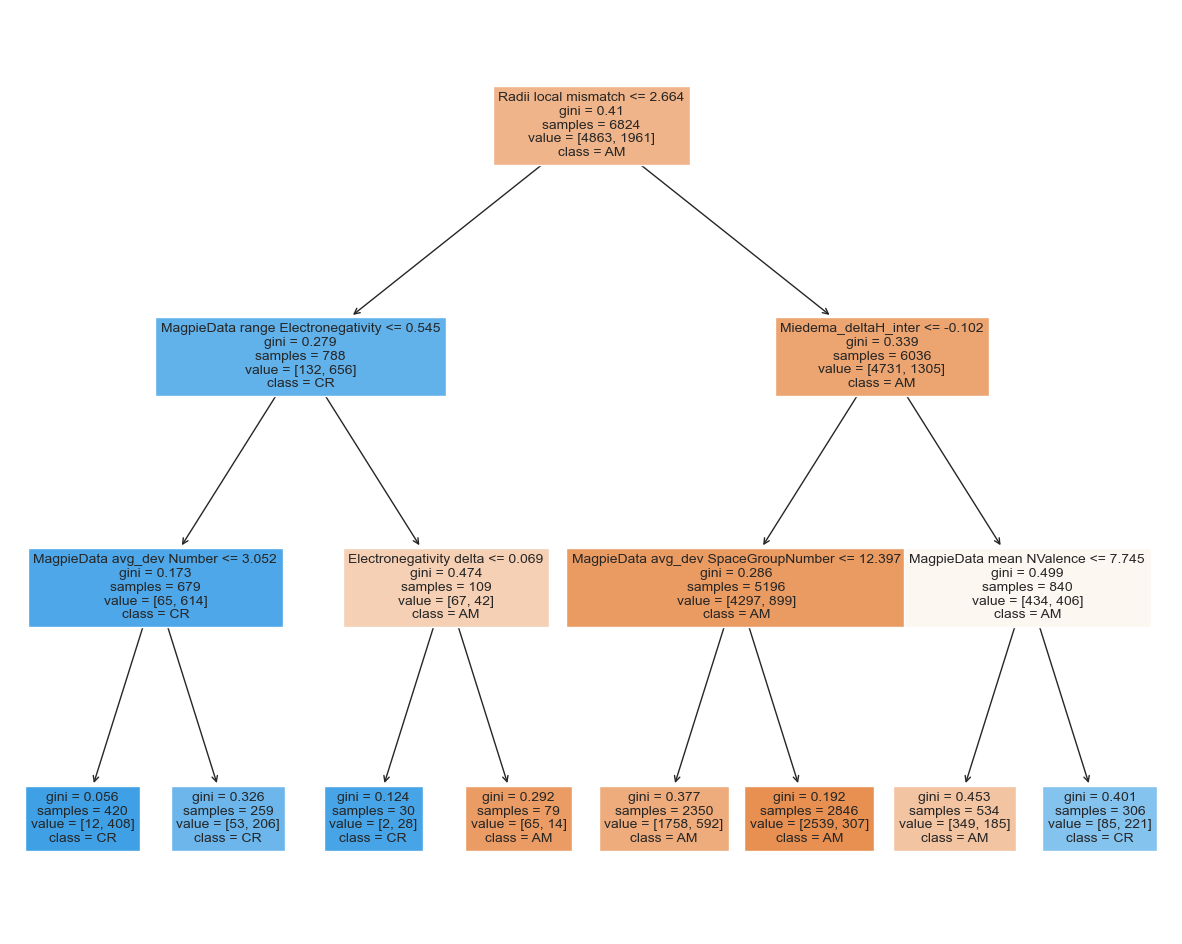

In [9]:
from sklearn import tree

#Use DT classification
DT = tree.DecisionTreeClassifier(max_depth=3, random_state = 42)
DT.fit(X_withcomp,y)   #no need for standardization for tree based methods

plt.figure(figsize = (15,12))
tree.plot_tree(DT, feature_names = X_withcomp.columns, class_names = y.unique(), filled = True, fontsize = 10)

#predict values using the model
y_hat = DT.predict(X_withcomp)

print(f'Depth: {DT.get_depth()}')
print(f'Number of leafs: {DT.get_n_leaves()}')
print(DT.get_params(deep=True))

**LOCO CV will be performed based on k means clustering method to test the model's generalizability. The data will be clustered into k clusters, trained on k-1 clusters and tested on the last cluster. It would be expectedThe clustering will be done in PCA space for better visualization.**

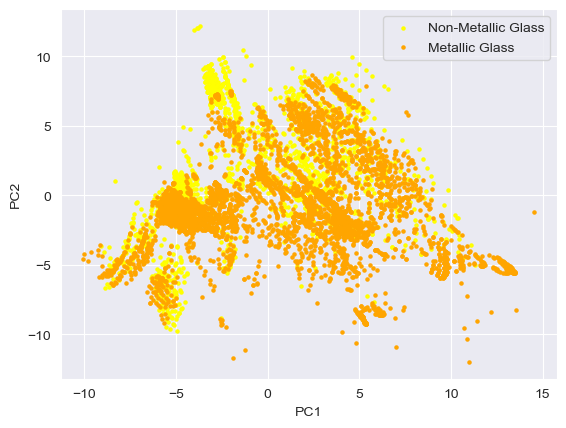

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()   #for PCA and clustering, standardization is needed
X_withcomp_std = sc.fit_transform(X_withcomp)
pca = PCA()
pca.fit(X_withcomp_std)
pos = pca.transform(X_withcomp_std)   #transform the pca

plt.scatter(pos[:,0][y=="CR"],pos[:,1][y=="CR"],s=5,c="yellow",label='Non-Metallic Glass')
plt.scatter(pos[:,0][y=="AM"],pos[:,1][y=="AM"],s=5,c="orange",label="Metallic Glass")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

**Perform k means clustering in PCA space. First, determine the number of clusters to use**

C:\Users\28452\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\28452\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\28452\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\28452\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\28452\anaconda3\lib\site-packages\sklearn\clust

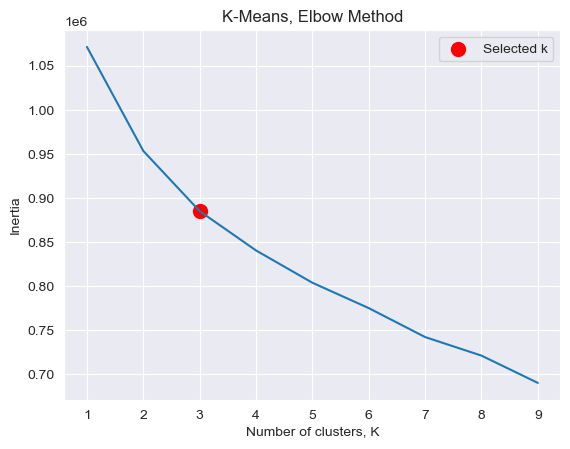

In [49]:
#perform k means clustering in PCA space
from sklearn.cluster import KMeans

inertias = {}

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, init='k-means++',random_state=42).fit(pos)
    inertias[k] = kmeans.inertia_

plt.figure()
plt.plot(list(inertias.keys()), list(inertias.values()))
plt.title('K-Means, Elbow Method')
plt.xlabel("Number of clusters, K")
plt.ylabel("Inertia")

plt.scatter(3,inertias[3],c='red',s=100,label='Selected k')
plt.legend()

**As shown in the inertial plot, the elbow is at around k=3. Therefore, clustering is performed with 3 clusters**

C:\Users\28452\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


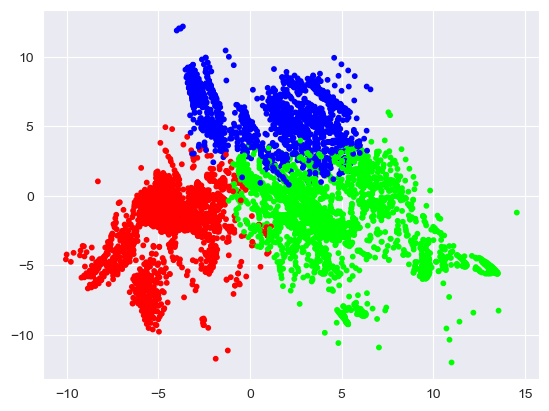

In [33]:
k = 3
kmeans = KMeans(n_clusters=k,init='k-means++', random_state = 42).fit(pos)
L = kmeans.labels_

plt.scatter(pos[:,0],pos[:,1],c=L,cmap='brg',s=10)   #plot the three clusters in pca space

**Perform LOCO CV with based on the three clusters, and show the result by confusion matrix and ROC curve. The max depth of the decision tree is set to be 3 to keep the model simple.**

In [13]:
from sklearn.model_selection import LeaveOneGroupOut

logo = LeaveOneGroupOut()
loco_list=[] #each group has: train_index, test_index, X_train, X_test, y_train, y_test

i=0
for train_index, test_index in logo.split(X_withcomp, y, L):
        print("TRAIN:", len(train_index), "TEST:", len(test_index))
        X_train, X_test = X_withcomp.to_numpy()[train_index], X_withcomp.to_numpy()[test_index]
        y_train, y_test = y.to_numpy()[train_index], y.to_numpy()[test_index]

        loco_list.append([train_index, test_index, X_train, X_test, y_train, y_test])

TRAIN: 5320 TEST: 1504
TRAIN: 4061 TEST: 2763
TRAIN: 4267 TEST: 2557


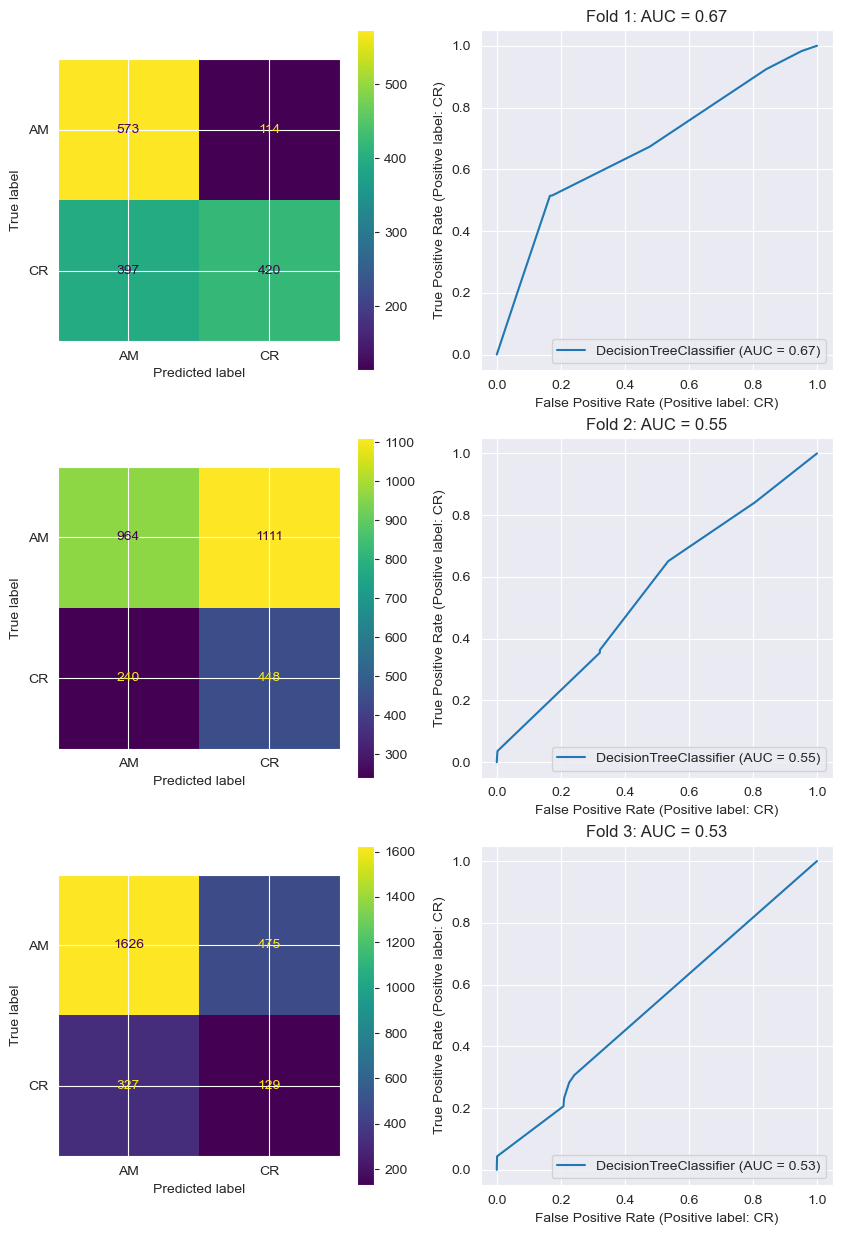

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, RocCurveDisplay
#plot the confusion matrix and the roc curve side by side for the three LOCO CV
fig, axs = plt.subplots(nrows=len(loco_list), ncols=2, figsize=(10, 5*len(loco_list)))

for i,group in enumerate(loco_list):
    train_index, test_index, X_train, X_test, y_train, y_test = group
    DT = tree.DecisionTreeClassifier(max_depth=3, random_state = 42)  #fit the decision tree with max_depth = 3
    DT.fit(X_train,y_train)
    y_hat = DT.predict(X_test)

    ConfusionMatrixDisplay.from_estimator(DT, X_test, y_test, ax=axs[i][0])
    AUC = roc_auc_score(y_test, DT.predict_proba(X_test)[:, 1])
    RocCurveDisplay.from_estimator(DT,X_test,y_test, ax=axs[i][1])
    axs[i][1].set_title('Fold {}: AUC = {:.2f}'.format(i+1, AUC))

**As expected, the LOCO CV performs poorly, with a mean AUC socre of around 0.583**

**After the LOGO CV, Gridsearch CV is performed, using random CV to select the "max_depth" and "min_samples_split" hyperparameters. A contour plot will be provided showing the AUC score for all the hyperparameter combinations**

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

tuned_parameters = [{'max_depth': [1,5,10,20,30],
                     'min_samples_split': [3,4,5,6,7,8]}]

score = 'roc_auc'

clf = GridSearchCV(
    tree.DecisionTreeClassifier(random_state=100), tuned_parameters,cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring = score)

clf.fit(X_withcomp, y)

print("Grid scores on development set:")
means = clf.cv_results_["mean_test_score"]
stds = clf.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds,
                             clf.cv_results_['params']):
    print(f"{mean:0.3f} (+/-{std*2:0.03f}) for {params}")

Best parameters set found on development set:

{'max_depth': 30, 'min_samples_split': 7}

Grid scores on development set:
0.645 (+/-0.030) for {'max_depth': 1, 'min_samples_split': 3}
0.645 (+/-0.030) for {'max_depth': 1, 'min_samples_split': 4}
0.645 (+/-0.030) for {'max_depth': 1, 'min_samples_split': 5}
0.645 (+/-0.030) for {'max_depth': 1, 'min_samples_split': 6}
0.645 (+/-0.030) for {'max_depth': 1, 'min_samples_split': 7}
0.645 (+/-0.030) for {'max_depth': 1, 'min_samples_split': 8}
0.817 (+/-0.027) for {'max_depth': 5, 'min_samples_split': 3}
0.817 (+/-0.027) for {'max_depth': 5, 'min_samples_split': 4}
0.817 (+/-0.027) for {'max_depth': 5, 'min_samples_split': 5}
0.817 (+/-0.027) for {'max_depth': 5, 'min_samples_split': 6}
0.817 (+/-0.027) for {'max_depth': 5, 'min_samples_split': 7}
0.818 (+/-0.026) for {'max_depth': 5, 'min_samples_split': 8}
0.857 (+/-0.020) for {'max_depth': 10, 'min_samples_split': 3}
0.859 (+/-0.021) for {'max_depth': 10, 'min_samples_split': 4}
0.865 (+

Text(0, 0.5, 'min_samples_split')

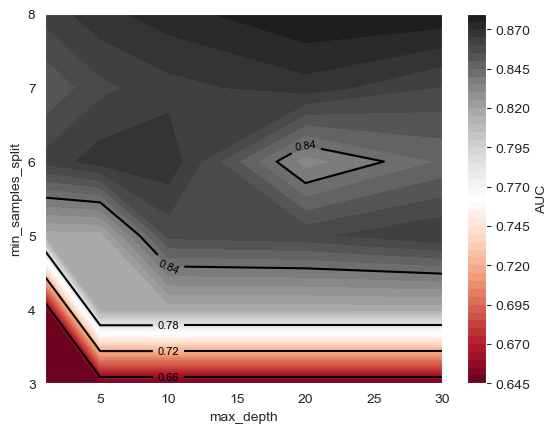

In [41]:
max_depth= [1,5,10,20,30]
min_samples_split= [3,4,5,6,7,8]

X, Y = np.meshgrid(max_depth, min_samples_split)
Z = np.array(means).reshape(6,5)

plt.figure()
plt.contourf(X, Y, Z, 50, cmap='RdGy')
plt.colorbar(label='AUC');

contours = plt.contour(X, Y, Z, 3, colors='black')
plt.clabel(contours, inline=True, fontsize=8)

plt.xlabel('max_depth')
plt.ylabel('min_samples_split')

**It can be seen from the contour plot that there is a local maximum of the roc score at around min_sample_split = 6 and max_depth = 6. Despite there are other regions where the score is high, since a relatively less complex model is preferred, the best hyperparameter for the decision tree is max_depth = 6 and min_samples_split = 6.**

**After the decision tree being fit on the data with the optima hyperparameters above, it has been found that the tree is too complex to visualize. Therefore, an additional step is taken to prune the tree by regularization. The regularization parameter (alpha) tuning process is done by Gridsearch CV as shown below, and the relationship between the alpha parameter and the AUC score is plotted as well.**

In [17]:
tuned_parameters = [{'ccp_alpha': np.logspace(-4, -1.5, 30)}]

score = 'roc_auc'

clf = GridSearchCV(
    tree.DecisionTreeClassifier(max_depth=6, min_samples_split=6, random_state = 42), tuned_parameters,cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring = score)
clf.fit(X_withcomp, y)

print("Grid scores on development set:")
means = clf.cv_results_["mean_test_score"]
stds = clf.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds,
                             clf.cv_results_['params']):
    print(f"{mean:0.3f} (+/-{std*2:0.03f}) for {params}")

Best parameters set found on development set:

{'ccp_alpha': 0.00032903445623126676}

Grid scores on development set:
0.844 (+/-0.012) for {'ccp_alpha': 0.0001}
0.843 (+/-0.012) for {'ccp_alpha': 0.00012195704601594415}
0.843 (+/-0.012) for {'ccp_alpha': 0.00014873521072935117}
0.843 (+/-0.012) for {'ccp_alpha': 0.00018139306939110632}
0.844 (+/-0.011) for {'ccp_alpha': 0.000221221629107045}
0.844 (+/-0.011) for {'ccp_alpha': 0.0002697953640072999}
0.845 (+/-0.012) for {'ccp_alpha': 0.00032903445623126676}
0.842 (+/-0.014) for {'ccp_alpha': 0.0004012807031942776}
0.842 (+/-0.013) for {'ccp_alpha': 0.0004893900918477494}
0.843 (+/-0.013) for {'ccp_alpha': 0.000596845699512231}
0.842 (+/-0.014) for {'ccp_alpha': 0.0007278953843983154}
0.843 (+/-0.016) for {'ccp_alpha': 0.0008877197088985861}
0.843 (+/-0.016) for {'ccp_alpha': 0.001082636733874054}
0.840 (+/-0.026) for {'ccp_alpha': 0.0013203517797162948}
0.841 (+/-0.027) for {'ccp_alpha': 0.0016102620275609393}
0.840 (+/-0.026) for {'ccp

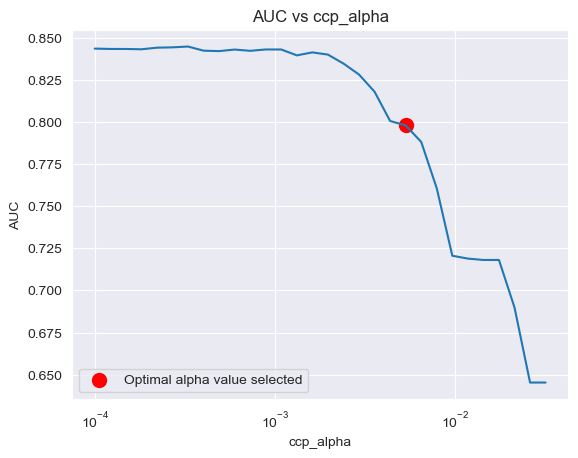

In [18]:
plt.figure()
plt.semilogx(np.logspace(-4, -1.5, 30), means)
plt.xlabel('ccp_alpha')
plt.ylabel('AUC')
plt.title('AUC vs ccp_alpha')
plt.scatter(np.logspace(-4, -1.5, 30)[np.where((means>0.79) & (means<0.8))], means[np.where((means>0.79) & (means<0.8))], color = 'red', s = 100, label = 'Optimal alpha value selected')   #highlight the optimal alpha value selected by Elbow Method
plt.legend()
plt.show()

**The optimal alpha lies on the elbow of the curve, meaning that it simplifies the model while still maintaining a high AUC score. The selected alpha value is approximately 0.0053**

### b. Train a full data model
**After the hyperparameters have been tuned, the optimal decision tree model is trained on the entire dataset and evaluated using confusion matrix and AUC curve. The final version tree is plotted**

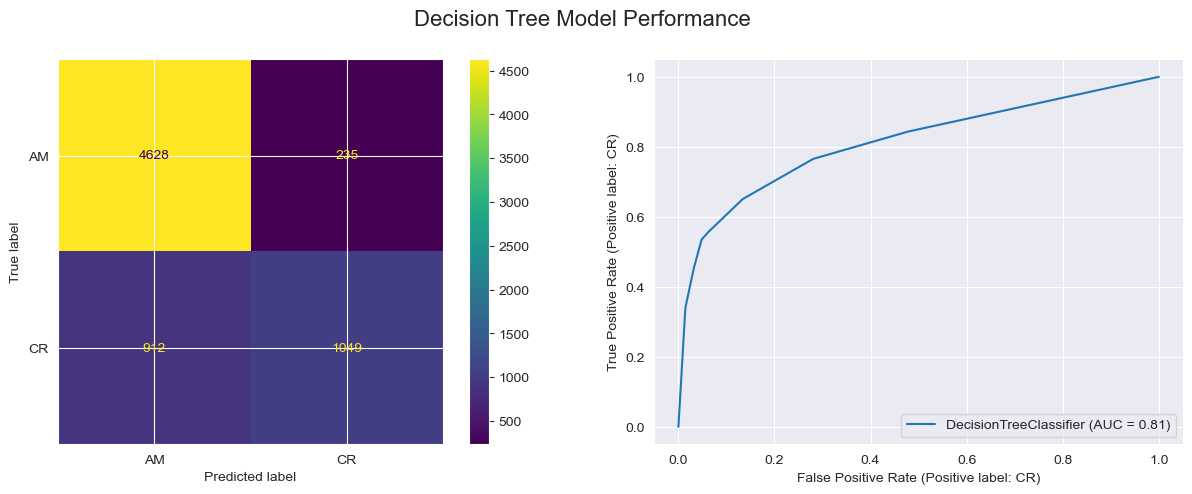

In [59]:
#Define the decision tree with the optimal hyperparameters
DT_preferred = tree.DecisionTreeClassifier(max_depth=6, min_samples_split=6, ccp_alpha=0.0053,random_state = 42)
DT_preferred.fit(X_withcomp, y)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.suptitle('Decision Tree Model Performance', fontsize=16)
ConfusionMatrixDisplay.from_estimator(DT_preferred, X_withcomp, y, ax=axs[0])
RocCurveDisplay.from_estimator(DT_preferred,X_withcomp,y, ax=axs[1])

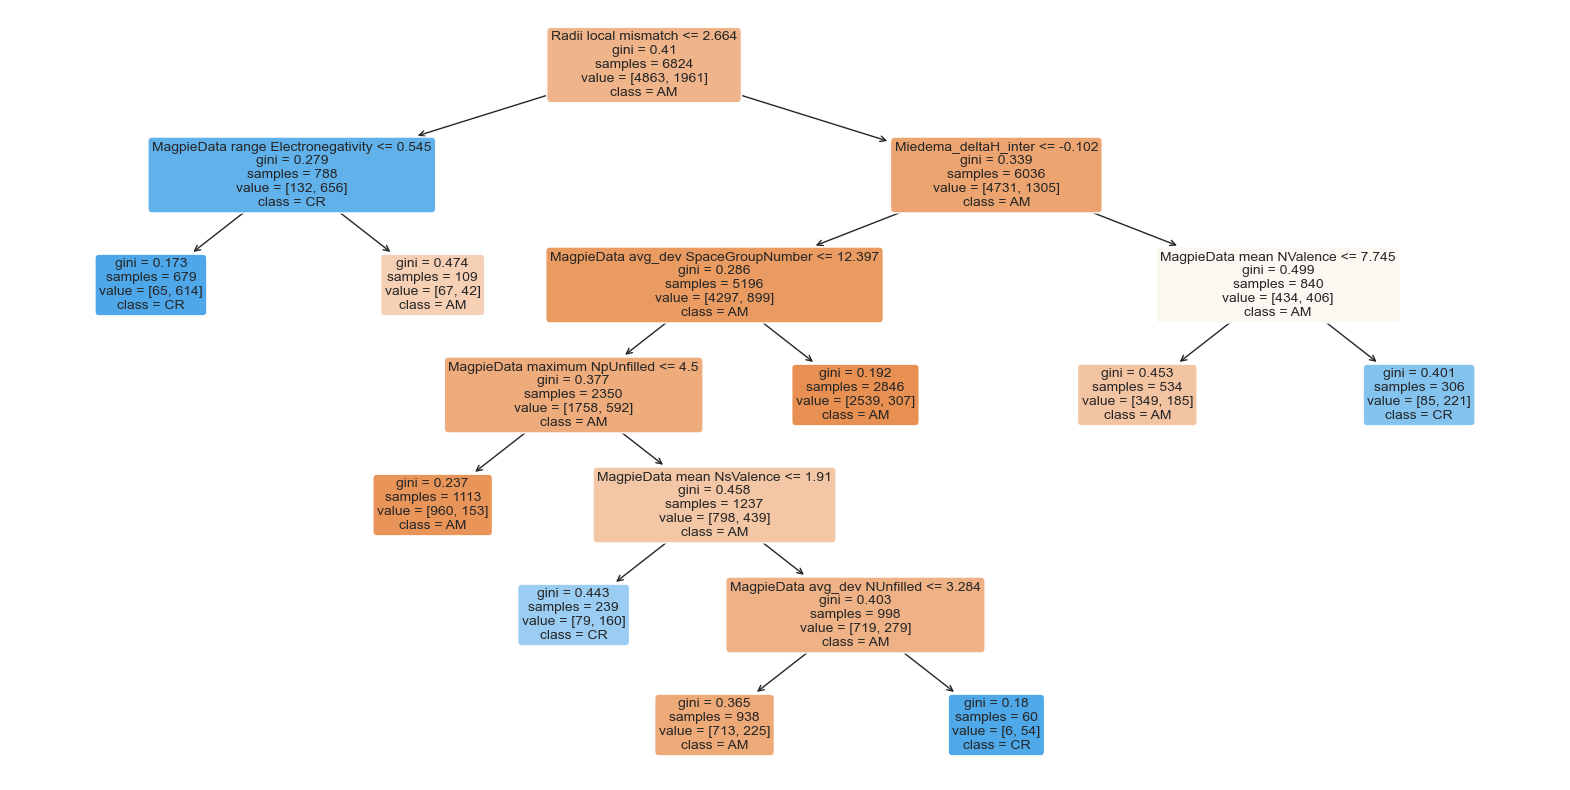

In [20]:
#plot the tree
plt.figure(figsize = (20,10))
tree.plot_tree(DT_preferred, feature_names = X_withcomp.columns, class_names = y.unique(), filled = True, rounded=True, fontsize = 10)

# remove the text
for text in plt.gca().texts:
    if text.get_text().startswith('('):
        text.set_text(text.get_text()[1:-1])

**Finally, the feature importance ranking is performed on the decision tree model and tested on its stability across random seeds**

In [21]:
seeds = np.linspace(1,100,50, dtype = int)

sum_importance_DT = np.zeros(len(X_withcomp.columns))
sum_std_importance_DT = np.zeros(len(X_withcomp.columns))
for seed in seeds:
    DT_preferred = tree.DecisionTreeClassifier(max_depth=6, min_samples_split=6, ccp_alpha=0.0053, random_state = seed)
    DT_preferred.fit(X_withcomp, y)
    importance = DT_preferred.feature_importances_
    sum_importance_DT += importance
    sum_std_importance_DT += importance**2


C:\Users\28452\AppData\Local\Temp\ipykernel_6496\2615369024.py:3: RuntimeWarning: invalid value encountered in sqrt
  std_importance_DT = np.sqrt(sum_std_importance_DT/len(seeds) - mean_importance_DT**2)


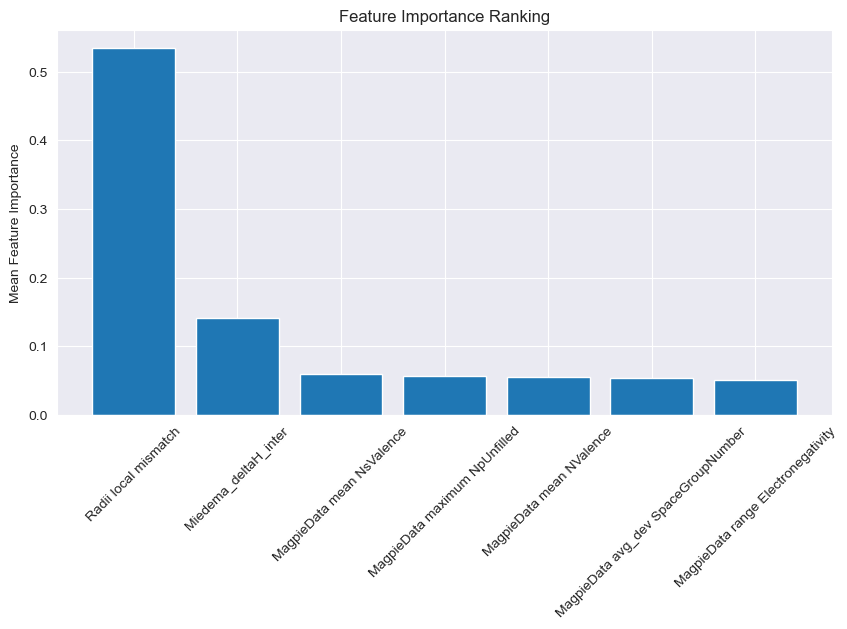

In [22]:
#plot the first seven most important mean feature importance with error bars
mean_importance_DT = sum_importance_DT/ len(seeds)
std_importance_DT = np.sqrt(sum_std_importance_DT/len(seeds) - mean_importance_DT**2)
cols = X_withcomp.columns
plt.figure(figsize = (10,5))

#sort the features by importance
sort_index = np.argsort(mean_importance_DT)[::-1]

mean_importance_DT = mean_importance_DT[sort_index]
std_importance_DT = std_importance_DT[sort_index]
cols = cols[sort_index]

plt.bar(cols[:7], mean_importance_DT[:7], yerr = std_importance_DT[:7])
plt.xticks(rotation = 45)
plt.ylabel('Mean Feature Importance')
plt.title('Feature Importance Ranking')



plt.show()

**The feature importance ranking is stable across random seeds, and the first seven most important features are shown above.**

## 3. Demonstrate your ability to generate a Random Forest classifier for this dataset
### a. Test your model’s generalizability by performing Cross Validation studies
Perform LOCO CV using random forest classifier based on the previous clusters

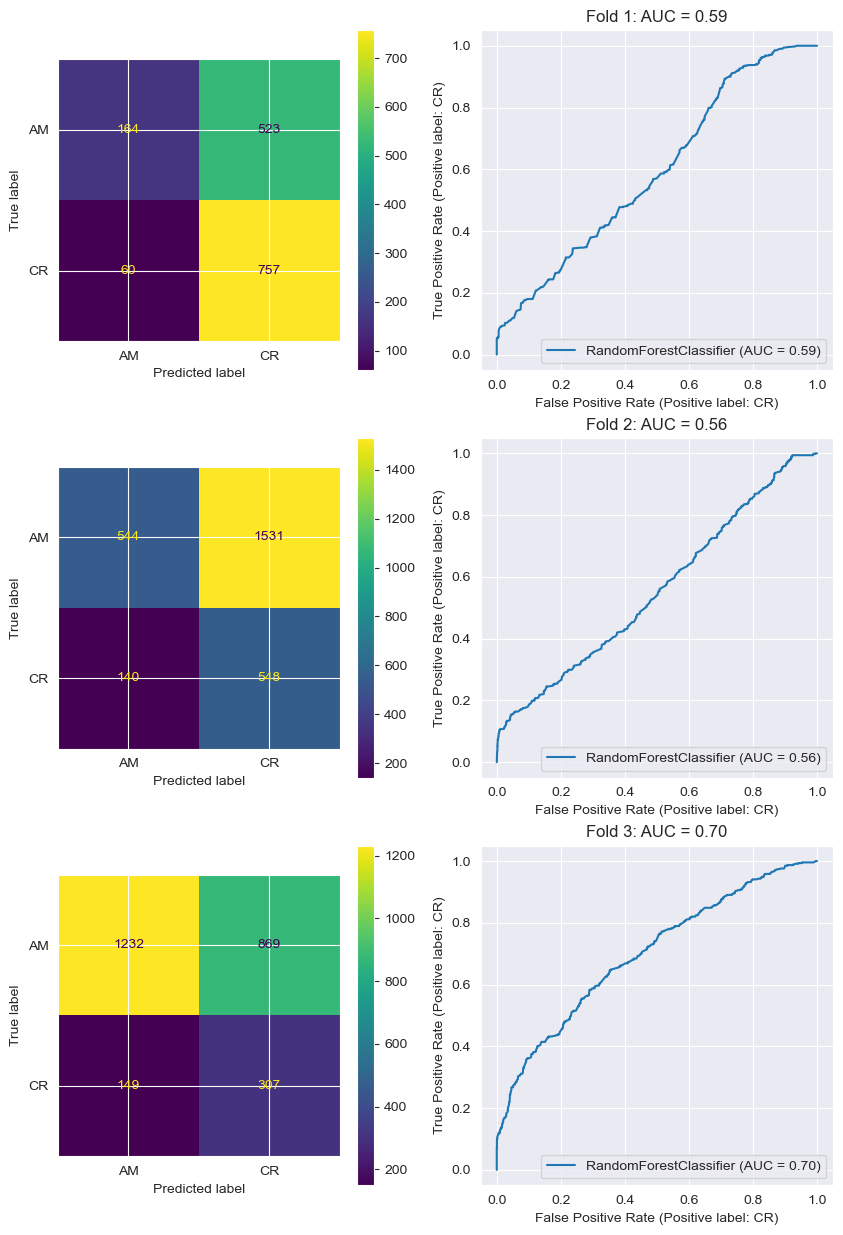

In [23]:
from sklearn.ensemble import RandomForestClassifier

fig, axs = plt.subplots(nrows=len(loco_list), ncols=2, figsize=(10, 5*len(loco_list)))

for i,group in enumerate(loco_list):
    train_index, test_index, X_train, X_test, y_train, y_test = group
    RFC = RandomForestClassifier(n_estimators=100, random_state = 42)

    RFC.fit(X_train,y_train)
    y_hat = RFC.predict(X_test)

    ConfusionMatrixDisplay.from_estimator(RFC, X_test, y_test, ax=axs[i][0])
    AUC = roc_auc_score(y_test, RFC.predict_proba(X_test)[:, 1])
    RocCurveDisplay.from_estimator(RFC,X_test,y_test, ax=axs[i][1])
    axs[i][1].set_title('Fold {}: AUC = {:.2f}'.format(i+1, AUC))

**The average AUC score for LOCO CV is around 0.617. As expected, it performs slightly better than the decision tree model, but still having low generalizability due to the nature of LOCO CV.**

**After that, the hyperparameters "max_depth" and "n_estimators" are tuned using GridSearchCV by random CV:**

In [24]:
tuned_parameters = [{'max_depth': [3,8,15,20,30],
                     'n_estimators': [10,50,100,200,300]}]

score = 'roc_auc'
clf = GridSearchCV(RandomForestClassifier(random_state = 42)
    , tuned_parameters,cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring = score)
clf.fit(X_withcomp, y)

print("Grid scores on development set:")
means = clf.cv_results_["mean_test_score"]
stds = clf.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds,
                             clf.cv_results_['params']):
    print(f"{mean:0.3f} (+/-{std*2:0.03f}) for {params}")

Best parameters set found on development set:

{'max_depth': 30, 'n_estimators': 200}

Grid scores on development set:
0.837 (+/-0.023) for {'max_depth': 3, 'n_estimators': 10}
0.851 (+/-0.018) for {'max_depth': 3, 'n_estimators': 50}
0.854 (+/-0.018) for {'max_depth': 3, 'n_estimators': 100}
0.855 (+/-0.016) for {'max_depth': 3, 'n_estimators': 200}
0.854 (+/-0.016) for {'max_depth': 3, 'n_estimators': 300}
0.925 (+/-0.010) for {'max_depth': 8, 'n_estimators': 10}
0.936 (+/-0.010) for {'max_depth': 8, 'n_estimators': 50}
0.938 (+/-0.013) for {'max_depth': 8, 'n_estimators': 100}
0.938 (+/-0.012) for {'max_depth': 8, 'n_estimators': 200}
0.939 (+/-0.012) for {'max_depth': 8, 'n_estimators': 300}
0.950 (+/-0.017) for {'max_depth': 15, 'n_estimators': 10}
0.961 (+/-0.013) for {'max_depth': 15, 'n_estimators': 50}
0.963 (+/-0.012) for {'max_depth': 15, 'n_estimators': 100}
0.964 (+/-0.011) for {'max_depth': 15, 'n_estimators': 200}
0.964 (+/-0.011) for {'max_depth': 15, 'n_estimators': 30

Text(0, 0.5, 'n_estimators')

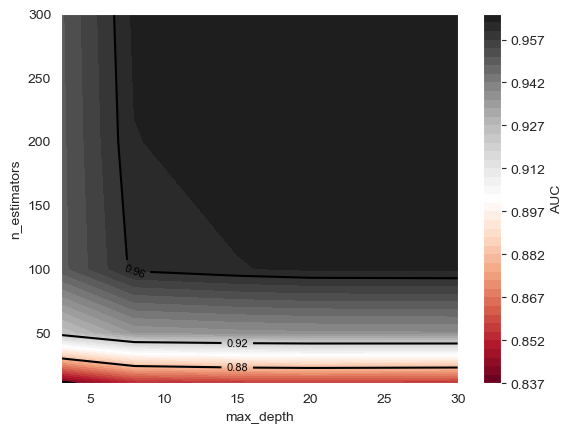

In [25]:
max_depth = [3,8,15,20,30]
n_estimators = [10,50,100,200,300]

X, Y = np.meshgrid(max_depth, n_estimators)
Z = np.array(means).reshape(5,5)

plt.figure()
plt.contourf(X, Y, Z, 50, cmap='RdGy')
plt.colorbar(label='AUC');

contours = plt.contour(X, Y, Z, 3, colors='black')
plt.clabel(contours, inline=True, fontsize=8)

plt.xlabel('max_depth')
plt.ylabel('n_estimators')

**From the contour plot, we will select the max_depth = 12 and n_estimators = 100, to get a decent result with a reasonable computation time and model complexity. To further reduce the model complexity and gain more interpretability, additional pruning step is added by tuning the alpha regularization hyperparameter.**

In [56]:
RFC_preferred = RandomForestClassifier(max_depth=12, n_estimators=100, random_state = 42)

tuned_parameters = [{'ccp_alpha': np.logspace(-4, -1.5, 30)}]

clf = GridSearchCV(
    RFC_preferred, tuned_parameters,cv=KFold(n_splits=5, shuffle=True, random_state=42),scoring = score)

clf.fit(X_withcomp, y)

print("Grid scores on development set:")
means = clf.cv_results_["mean_test_score"]
stds = clf.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds,
                             clf.cv_results_['params']):
    print(f"{mean:0.3f} (+/-{std*2:0.03f}) for {params}")

Grid scores on development set:
0.959 (+/-0.013) for {'ccp_alpha': 0.0001}
0.959 (+/-0.013) for {'ccp_alpha': 0.00012195704601594415}
0.959 (+/-0.013) for {'ccp_alpha': 0.00014873521072935117}
0.958 (+/-0.013) for {'ccp_alpha': 0.00018139306939110632}
0.958 (+/-0.013) for {'ccp_alpha': 0.000221221629107045}
0.957 (+/-0.013) for {'ccp_alpha': 0.0002697953640072999}
0.956 (+/-0.013) for {'ccp_alpha': 0.00032903445623126676}
0.954 (+/-0.013) for {'ccp_alpha': 0.0004012807031942776}
0.953 (+/-0.014) for {'ccp_alpha': 0.0004893900918477494}
0.951 (+/-0.014) for {'ccp_alpha': 0.000596845699512231}
0.947 (+/-0.014) for {'ccp_alpha': 0.0007278953843983154}
0.943 (+/-0.014) for {'ccp_alpha': 0.0008877197088985861}
0.938 (+/-0.014) for {'ccp_alpha': 0.001082636733874054}
0.932 (+/-0.014) for {'ccp_alpha': 0.0013203517797162948}
0.925 (+/-0.014) for {'ccp_alpha': 0.0016102620275609393}
0.917 (+/-0.014) for {'ccp_alpha': 0.00196382800192977}
0.908 (+/-0.015) for {'ccp_alpha': 0.002395026619987486}

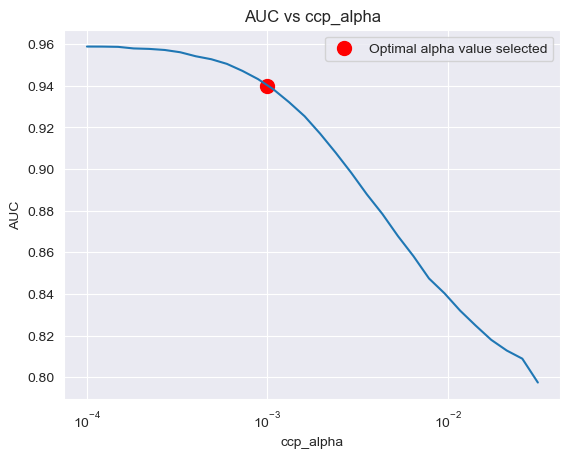

In [27]:
# plot the results
plt.figure()
plt.semilogx(np.logspace(-4, -1.5, 30), means)
plt.xlabel('ccp_alpha')
plt.ylabel('AUC')
plt.title('AUC vs ccp_alpha')

plt.scatter(0.001, 0.94, color = 'red', s = 100, label = 'Optimal alpha value selected')
plt.legend()
plt.show()

**The optimal alpha value is 0.001, which is used to prune the tree.**

**Again, feature importance ranking is performed across 10 random seeds**

In [28]:
seeds = np.linspace(1,100,50, dtype = int)

#for each random state seed perform perfered random forest on the entire data, and get the mean feature importance across all the seeds, and an error bar for the standard deviation
mean_importance = np.zeros(len(X_withcomp.columns))
std_importance = np.zeros(len(X_withcomp.columns))
for seed in seeds:
    RFC_preferred = RandomForestClassifier(max_depth=12, n_estimators=100, ccp_alpha=0.001, random_state = seed)
    RFC_preferred.fit(X_withcomp, y)
    importance = RFC_preferred.feature_importances_
    mean_importance += importance
    std_importance += importance**2


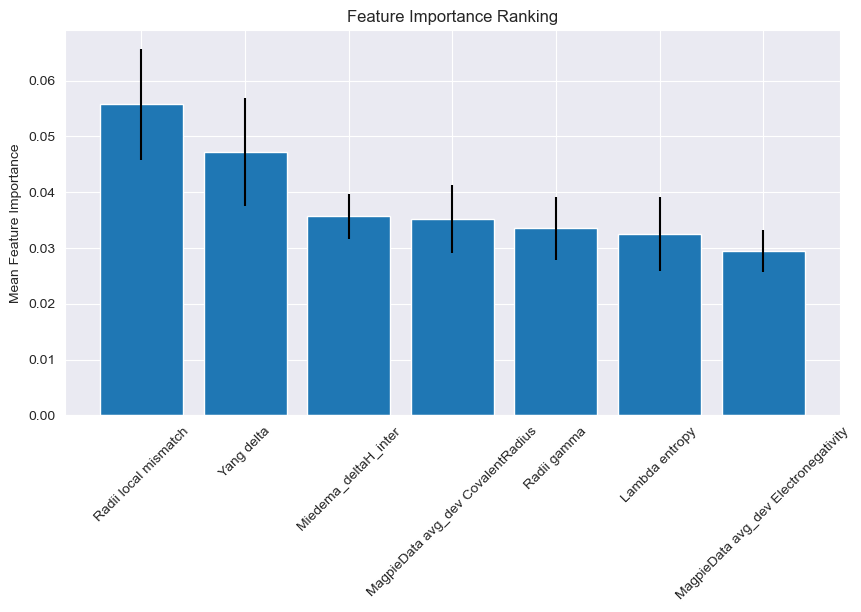

In [29]:
#plot the first seven most important mean feature importance with error bars
mean_importance /= len(seeds)
std_importance = np.sqrt(std_importance/len(seeds) - mean_importance**2)
cols = X_withcomp.columns

plt.figure(figsize = (10,5))

#sort the features by importance
sort_index = np.argsort(mean_importance)[::-1]
mean_importance_2 = mean_importance[sort_index]
std_importance = std_importance[sort_index]
cols = cols[sort_index]

plt.bar(cols[:7], mean_importance_2[:7], yerr = std_importance[:7])
plt.xticks(rotation = 45)
plt.ylabel('Mean Feature Importance')
plt.title('Feature Importance Ranking')
#make sure the x label is aligned with the bars
#plt.tight_layout()

plt.show()

**The most important features are the same as the decision tree model, note that the feature importances are not stable across random seeds, an error bar is provided showing the standard deviation for the feature importance across all the random seeds. It can be seen that the feature importances are more balanced for the random forest model compared to the single decision tree model, but the important features are similar.**

### b. Train a full data model
**After the hyperparameter tuning, the model is trained on the entire data, and the result is shown by confusion matrix and ROC curve, displayed side by side.**

Text(0.5, 1.0, 'AUC = 0.9654')

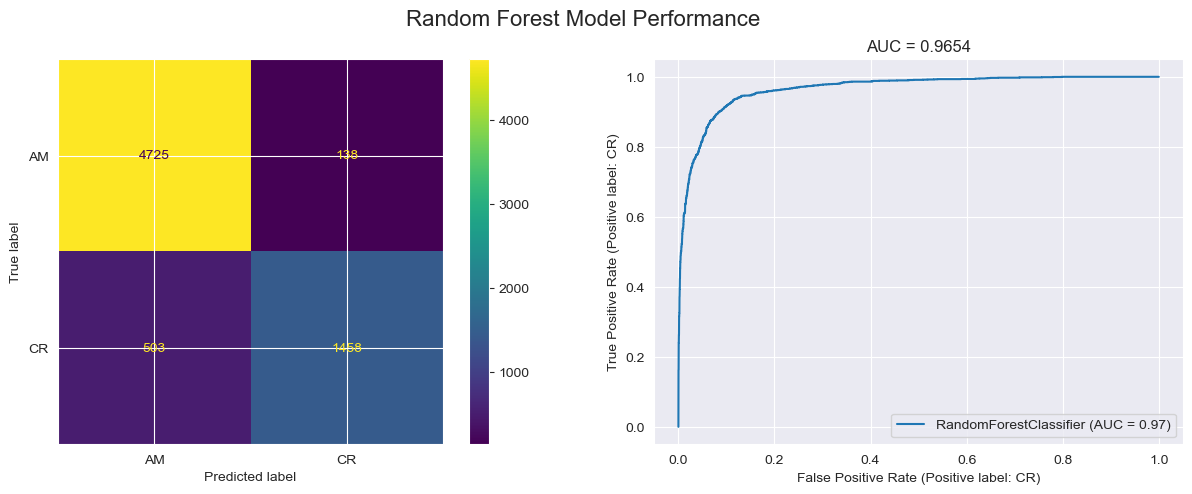

In [58]:
RFC_preferred = RandomForestClassifier(max_depth=12, n_estimators=100, ccp_alpha=0.001, random_state = 42)
RFC_preferred.fit(X_withcomp, y)
y_hat = RFC_preferred.predict(X_withcomp)

fig, axs = plt.subplots(1,2, figsize = (15,5))
fig.suptitle('Random Forest Model Performance', fontsize=16)
ConfusionMatrixDisplay.from_estimator(RFC_preferred, X_withcomp, y, ax=axs[0])
AUC = roc_auc_score(y, RFC_preferred.predict_proba(X_withcomp)[:, 1])
RocCurveDisplay.from_estimator(RFC_preferred,X_withcomp,y, ax=axs[1])
axs[1].set_title('AUC = {:.4f}'.format(AUC))

**It is shown that the random forest model has a AUC score of 0.9654, which is more outstanding than the single decision tree model (the decision tree model has an AUC score of 0.81).**

## 4. Predict the Glass forming ability for the entire Co-Zr-Cr-Ti quaternary system (use 5 at.% increments) using both your Decision Tree and Random Forest models.
**First, generate the quaternary dataset**

In [31]:
dict_entire_qua = {'Cr':[], 'Co':[], 'Ti':[], 'Zr':[]}  #copilot

for cr in np.arange(0,1.05,0.05):   #Creat the quaternary composition dataframe with 5 at.% increments
    for ti in np.arange(0,1.05,0.05):
        for co in np.arange(0,1.05,0.05):
            for zr in np.arange(0,1.05,0.05):
                if round(cr+ti+co+zr, 4) == 1.0:
                    dict_entire_qua['Cr'].append(round(cr,3))
                    dict_entire_qua['Ti'].append(round(ti,3))
                    dict_entire_qua['Co'].append(round(co,3))
                    dict_entire_qua['Zr'].append(round(zr,3))
df_entire_qua = pd.DataFrame(dict_entire_qua)


**Build the feature set in the same way as the training data**

In [32]:
formula = 'Cr'+df_entire_qua['Cr'].astype(str)+'Ti'+df_entire_qua['Ti'].astype(str)+'Co'+df_entire_qua['Co'].astype(str)+'Zr'+df_entire_qua['Zr'].astype(str)
df_entire_mat = pd.DataFrame({'Formula':formula})

#convert the formula from a string into chemical composition
df_entire_mat = StrToComposition().featurize_dataframe(df_entire_mat, "Formula")
df_entire_mat = Miedema().featurize_dataframe(df_entire_mat, col_id="composition")
df_entire_mat = WenAlloys().featurize_dataframe(df_entire_mat, col_id="composition")

NameError: name 'StrToComposition' is not defined

In [ ]:
ep_feat = ElementProperty.from_preset(preset_name='magpie')

df_entire_mat = ep_feat.featurize_dataframe(df_entire_mat, col_id = 'composition')

In [ ]:
df_entire_mat = df_entire_mat.drop(['Weight Fraction','Atomic Fraction','composition','Formula'],axis=1,errors='ignore')
#add composition data
df_entire_mat = df_entire_mat.drop(['Cr','Ti','Co','Zr'],axis=1,errors='ignore')

df_entire_mat_comp = pd.concat([df_entire_qua,df_entire_mat],axis=1)
#for the columns that are not in the columns of X_withcomp, add them to df_entire_mat_comp and fill them with zeros
entire_mat = df_entire_mat_comp.drop(to_drop,axis=1,errors='ignore')
for col in X_withcomp.columns:
    if col not in entire_mat.columns:
        entire_mat[col] = 0

entire_mat.to_csv('Matminer_Quaternary.csv',index=False)

In [51]:
entire_X = pd.read_csv('Matminer_Quaternary.csv')
delta = entire_X['Yang delta']   #Extract the delta and omega values for the Yang's plot
omega = entire_X['Yang omega']
entire_X = entire_X[X_withcomp.columns]

### a. Compare your predictions via RFC and DT
First, the predictions are made using the optimal RFC and DT models from the previous section.

In [52]:
DT_preferred = tree.DecisionTreeClassifier(max_depth=6, min_samples_split=6, ccp_alpha=0.0053,random_state = 42)
DT_preferred.fit(X_withcomp, y)
entire_y_hat_DT = DT_preferred.predict(entire_X)

RFC_preferred = RandomForestClassifier(max_depth=12, n_estimators=100, ccp_alpha=0.001, random_state = 42)
RFC_preferred.fit(X_withcomp, y)
entire_y_hat_RFC = RFC_preferred.predict(entire_X)

**The predictions from the two models are shown in Yang plots**

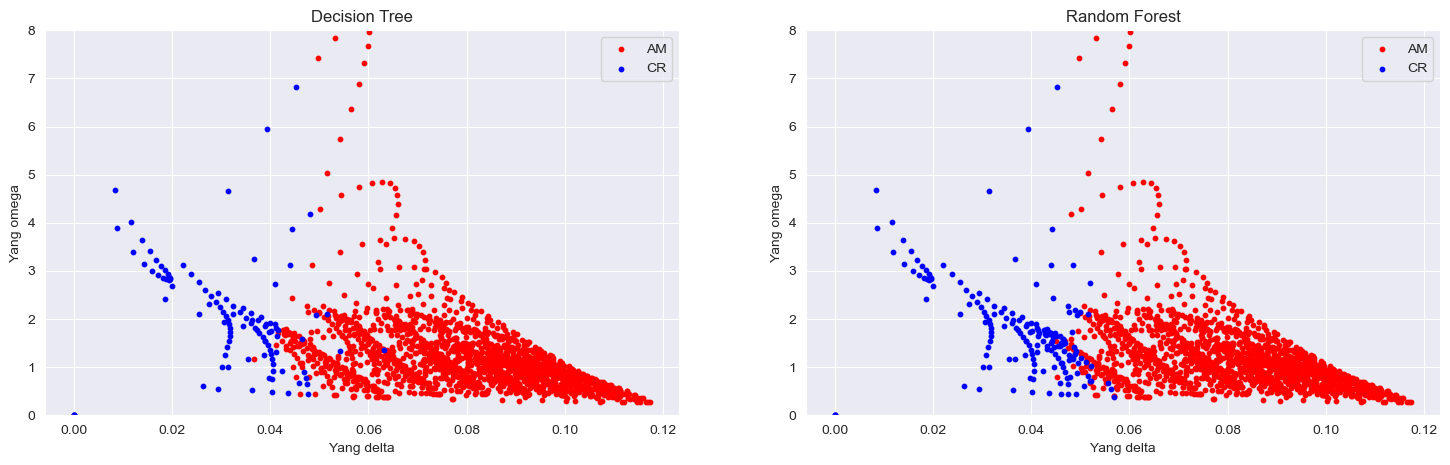

In [61]:
plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
plt.scatter(delta[entire_y_hat_DT=='AM'], omega[entire_y_hat_DT=='AM'], c='r', label='AM',s=10)
plt.scatter(delta[entire_y_hat_DT=='CR'], omega[entire_y_hat_DT=='CR'], c='b', label='CR',s=10)
plt.ylim(0,8)
plt.title('Decision Tree')
plt.xlabel('Yang delta')
plt.ylabel('Yang omega')
plt.legend()

plt.subplot(1,2,2)
plt.scatter(delta[entire_y_hat_RFC=='AM'], omega[entire_y_hat_RFC=='AM'], c='r', label='AM',s=10)
plt.scatter(delta[entire_y_hat_RFC=='CR'], omega[entire_y_hat_RFC=='CR'], c='b', label='CR',s=10)
plt.ylim(0,8)
plt.title('Random Forest')
plt.xlabel('Yang delta')
plt.ylabel('Yang omega')
plt.legend()

**The predictions of the two models are also shown in pca space, compared to each other and the ground truth**

In [54]:
sc = StandardScaler()
entire_X_std = sc.fit_transform(entire_X)
pca = PCA()
pos_RFC = pca.fit_transform(entire_X_std)
#strandareize the data and perform pca

Text(0.5, 1.0, 'Actual Result in PCA Space')

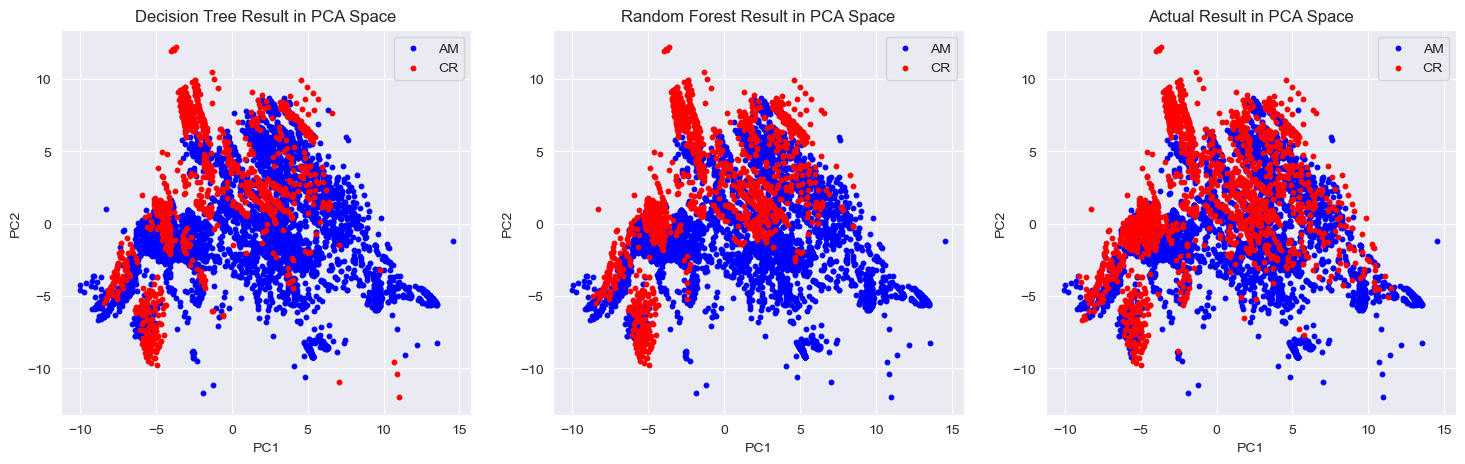

In [55]:
DT_preferred = tree.DecisionTreeClassifier(max_depth=6, min_samples_split=6, ccp_alpha=0.0053,random_state = 42)
DT_preferred.fit(X_withcomp, y)
y_hat_DT = DT_preferred.predict(X_withcomp)   #predictions from DT

plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.scatter(pos[:,0][y_hat_DT=='AM'], pos[:,1][y_hat_DT=='AM'], color = 'blue', label = 'AM',s=10)
plt.scatter(pos[:,0][y_hat_DT=='CR'], pos[:,1][y_hat_DT=='CR'], color = 'red', label = 'CR',s=10)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.title('Decision Tree Result in PCA Space')

RFC_preferred = RandomForestClassifier(max_depth=12, n_estimators=100, ccp_alpha=0.001, random_state = 42)
RFC_preferred.fit(X_withcomp, y)
y_hat_RFC = RFC_preferred.predict(X_withcomp)   #predictions from RFC

plt.subplot(1,3,2)
plt.scatter(pos[:,0][y_hat_RFC=='AM'], pos[:,1][y_hat_RFC=='AM'], color = 'blue', label = 'AM',s=10)
plt.scatter(pos[:,0][y_hat_RFC=='CR'], pos[:,1][y_hat_RFC=='CR'], color = 'red', label = 'CR',s=10)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.title('Random Forest Result in PCA Space')

plt.subplot(1,3,3)   #Plotting the ground truth
plt.scatter(pos[:,0][y=='AM'], pos[:,1][y=='AM'], color = 'blue', label = 'AM',s=10)
plt.scatter(pos[:,0][y=='CR'], pos[:,1][y=='CR'], color = 'red', label = 'CR',s=10)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.title('Actual Result in PCA Space')

**The predictions on the training set are also shown and compared on Yang's Plot**

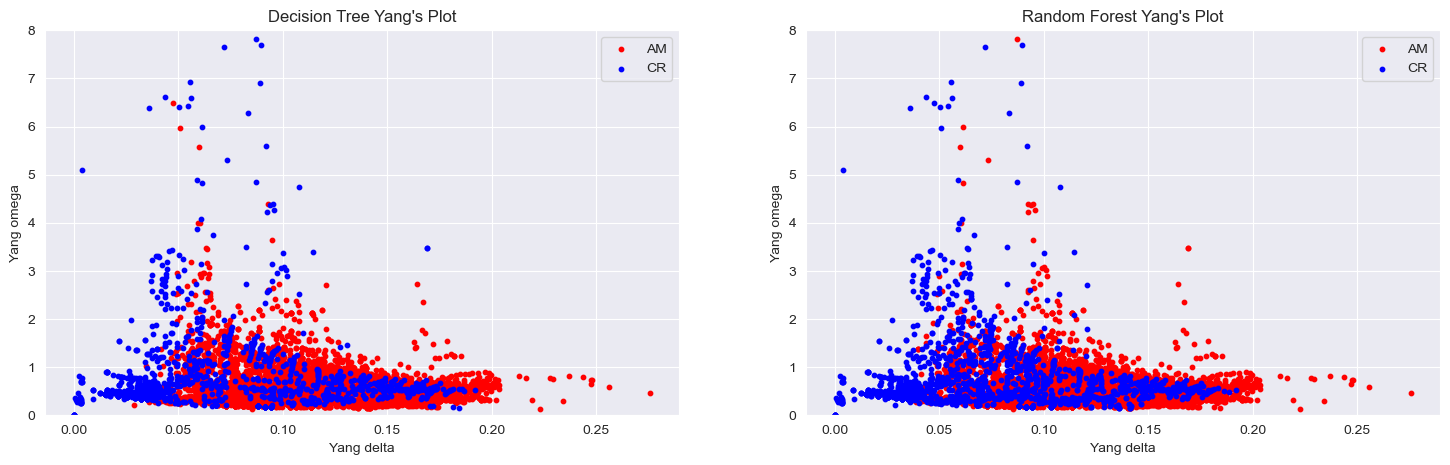

In [64]:
delta_train = X_withcomp['Yang delta']
omega_train = X_withcomp['Yang omega']

plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.scatter(delta_train[y_hat_DT=='AM'], omega_train[y_hat_DT=='AM'], c='r', label='AM',s=10)
plt.scatter(delta_train[y_hat_DT=='CR'], omega_train[y_hat_DT=='CR'], c='b', label='CR',s=10)
plt.ylim(0,8)
plt.title('Decision Tree Yang\'s Plot')
plt.xlabel('Yang delta')
plt.ylabel('Yang omega')
plt.legend()

plt.subplot(1,2,2)
plt.scatter(delta_train[y_hat_RFC=='AM'], omega_train[y_hat_RFC=='AM'], c='r', label='AM',s=10)
plt.scatter(delta_train[y_hat_RFC=='CR'], omega_train[y_hat_RFC=='CR'], c='b', label='CR',s=10)
plt.ylim(0,8)
plt.title('Random Forest Yang\'s Plot')
plt.xlabel('Yang delta')
plt.ylabel('Yang omega')
plt.legend()

**The training data contains a vareity of different alloys, and the predictions are made only on the Cr, Co, Ti, Zr quaternary system. Another model will be built, with the same hyperparameter, but only with training data that contain Cr, Co, Ti, or Zr composition, and predict the glass forming ability of the quaternary system.**

In [74]:
#Extract the data points that contain Cr, Co, Ti, or Zr
X_withcomp_qua = X_withcomp[(X_withcomp['Ti']!=0) | (X_withcomp['Cr']!=0) | (X_withcomp['Co']!=0) | (X_withcomp['Zr']!=0)]
y_qua = y[(X_withcomp['Ti']!=0) | (X_withcomp['Cr']!=0) | (X_withcomp['Co']!=0) | (X_withcomp['Zr']!=0)]
y_hat_DT_qua = y_hat_DT[(X_withcomp['Ti']!=0) | (X_withcomp['Cr']!=0) | (X_withcomp['Co']!=0) | (X_withcomp['Zr']!=0)]
y_hat_RFC_qua = y_hat_RFC[(X_withcomp['Ti']!=0) | (X_withcomp['Cr']!=0) | (X_withcomp['Co']!=0) | (X_withcomp['Zr']!=0)]
Yang_delta_train_qua = delta_train[(X_withcomp['Ti']!=0) | (X_withcomp['Cr']!=0) | (X_withcomp['Co']!=0) | (X_withcomp['Zr']!=0)]
Yang_omega_train_qua = omega_train[(X_withcomp['Ti']!=0) | (X_withcomp['Cr']!=0) | (X_withcomp['Co']!=0) | (X_withcomp['Zr']!=0)]

**Showing training data on Yang\'s plot only with alloys that contain Cr, Co, Ti, or Zr**

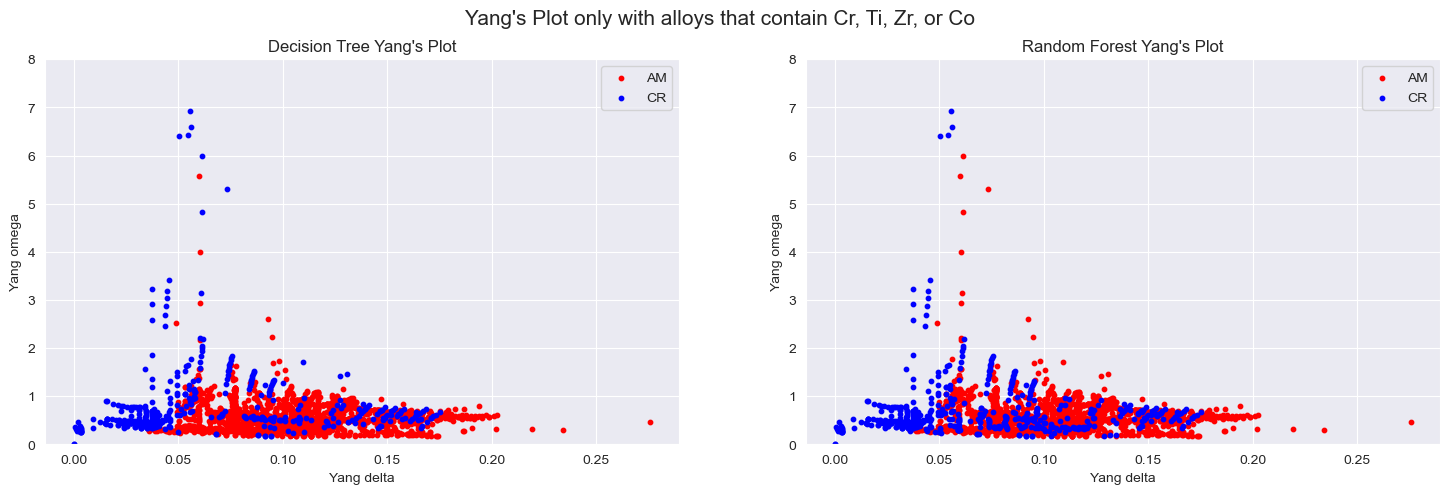

In [73]:
plt.figure(figsize=(18,5))
plt.suptitle('Yang\'s Plot only with alloys that contain Cr, Ti, Zr, or Co', fontsize=15)

plt.subplot(1,2,1)
plt.scatter(Yang_delta_train_qua[y_hat_DT_qua=='AM'], Yang_omega_train_qua[y_hat_DT_qua=='AM'], c='r', label='AM',s=10)
plt.scatter(Yang_delta_train_qua[y_hat_DT_qua=='CR'], Yang_omega_train_qua[y_hat_DT_qua=='CR'], c='b', label='CR',s=10)
plt.ylim(0,8)
plt.title('Decision Tree Yang\'s Plot')
plt.xlabel('Yang delta')
plt.ylabel('Yang omega')
plt.legend()

plt.subplot(1,2,2)
plt.scatter(Yang_delta_train_qua[y_hat_RFC_qua=='AM'], Yang_omega_train_qua[y_hat_RFC_qua=='AM'], c='r', label='AM',s=10)
plt.scatter(Yang_delta_train_qua[y_hat_RFC_qua=='CR'], Yang_omega_train_qua[y_hat_RFC_qua=='CR'], c='b', label='CR',s=10)
plt.ylim(0,8)
plt.title('Random Forest Yang\'s Plot')
plt.xlabel('Yang delta')
plt.ylabel('Yang omega')
plt.legend()

In [76]:
DT_preferred = tree.DecisionTreeClassifier(max_depth=6, min_samples_split=6, ccp_alpha=0.0053,random_state = 42)
DT_preferred.fit(X_withcomp_qua, y_qua)
entire_y_hat_DT_qua = DT_preferred.predict(entire_X)   #predictions from DT

RFC_preferred = RandomForestClassifier(max_depth=12, n_estimators=100, ccp_alpha=0.001, random_state = 42)
RFC_preferred.fit(X_withcomp_qua, y_qua)
entire_y_hat_RFC_qua = RFC_preferred.predict(entire_X)   #predictions from RFC


**Finally, showing the predictions of the model built only with training data that contains the elements in the quaternary system, compared to the predictions of the model that is built on the entire training set**

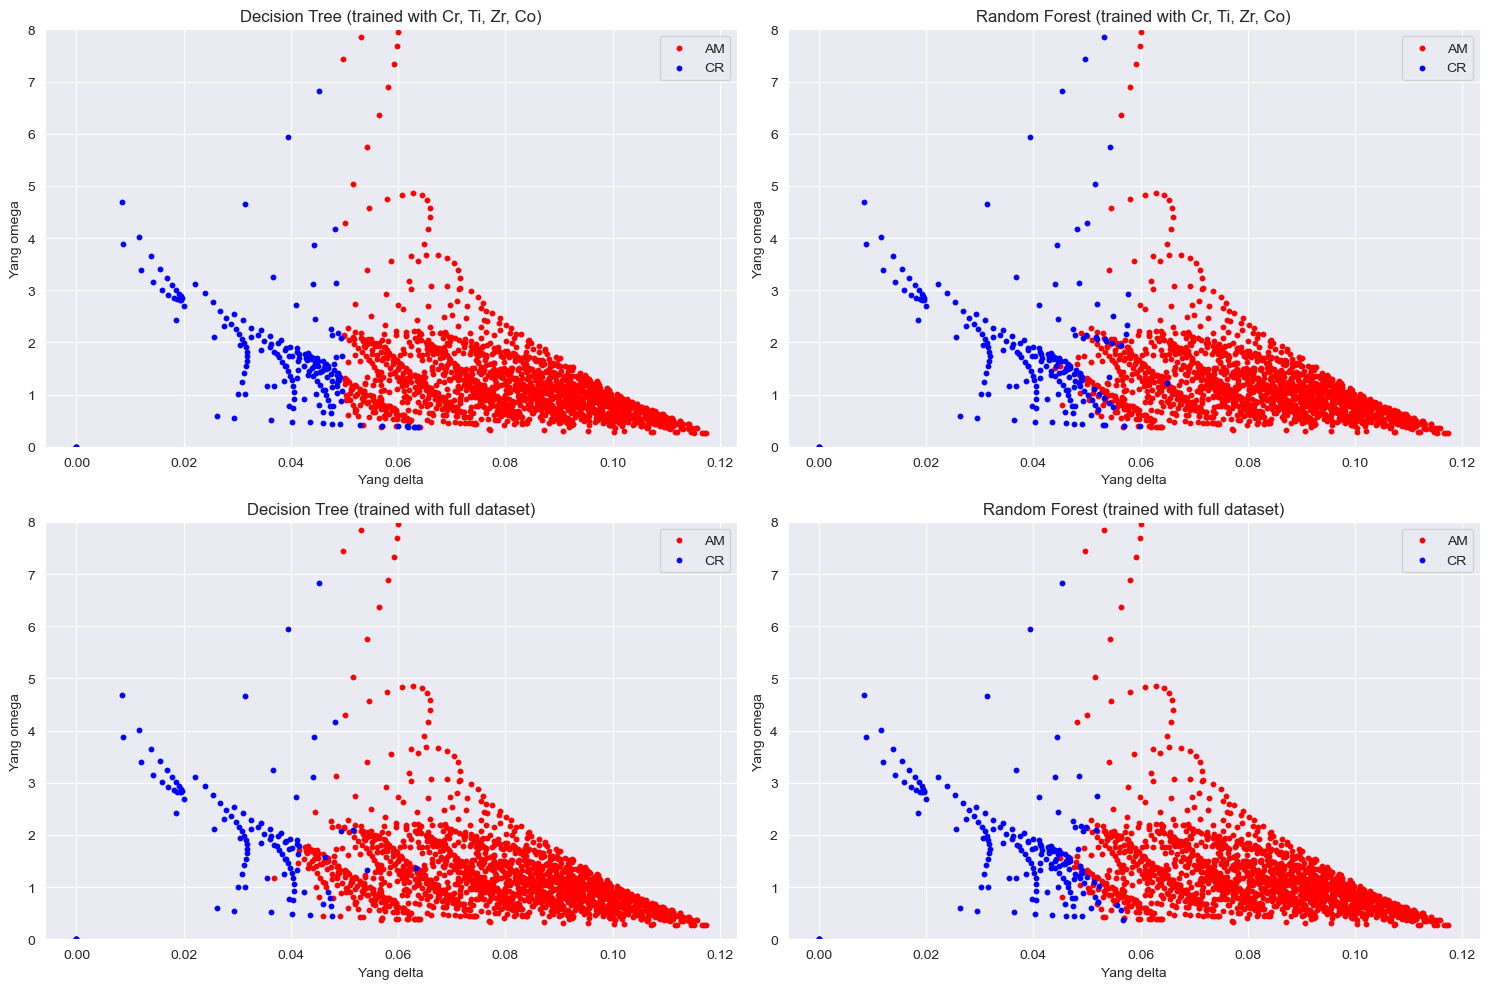

In [83]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.scatter(delta[entire_y_hat_DT_qua=='AM'], omega[entire_y_hat_DT_qua=='AM'], c='r', label='AM',s=10)
plt.scatter(delta[entire_y_hat_DT_qua=='CR'], omega[entire_y_hat_DT_qua=='CR'], c='b', label='CR',s=10)
plt.ylim(0,8)
plt.title('Decision Tree (trained with Cr, Ti, Zr, Co)')
plt.xlabel('Yang delta')
plt.ylabel('Yang omega')
plt.legend()

plt.subplot(2,2,2)
plt.scatter(delta[entire_y_hat_RFC_qua=='AM'], omega[entire_y_hat_RFC_qua=='AM'], c='r', label='AM',s=10)
plt.scatter(delta[entire_y_hat_RFC_qua=='CR'], omega[entire_y_hat_RFC_qua=='CR'], c='b', label='CR',s=10)
plt.ylim(0,8)
plt.title('Random Forest (trained with Cr, Ti, Zr, Co)')
plt.xlabel('Yang delta')
plt.ylabel('Yang omega')
plt.legend()

plt.subplot(2,2,3)
plt.scatter(delta[entire_y_hat_DT=='AM'], omega[entire_y_hat_DT=='AM'], c='r', label='AM',s=10)
plt.scatter(delta[entire_y_hat_DT=='CR'], omega[entire_y_hat_DT=='CR'], c='b', label='CR',s=10)
plt.ylim(0,8)
plt.title('Decision Tree (trained with full dataset)')
plt.xlabel('Yang delta')
plt.ylabel('Yang omega')
plt.legend()

plt.subplot(2,2,4)
plt.scatter(delta[entire_y_hat_RFC=='AM'], omega[entire_y_hat_RFC=='AM'], c='r', label='AM',s=10)
plt.scatter(delta[entire_y_hat_RFC=='CR'], omega[entire_y_hat_RFC=='CR'], c='b', label='CR',s=10)
plt.ylim(0,8)
plt.title('Random Forest (trained with full dataset)')
plt.xlabel('Yang delta')
plt.ylabel('Yang omega')
plt.legend()
plt.tight_layout()

**Generally, the models provide similar predictions. It can be seen that the predictions of the decision tree trained with data only contain the element in the quaternary system are closer to the ones from random forest models**

# Summary

This lab report provides a comprehensive analysis of the metallic glass forming ability of the Co-Zr-Cr-Ti quaternary system using decision tree and random forest classifiers. The goal of the study was to generate physically defensible models of glass forming ability for the entire quaternary system using a training dataset of approximately 7000 alloys.

The first step of the analysis involved data preparation and cleaning. For simplicity, all AC alloys were labeled as CR, and a set of over 150 features was generated using Magpie and MatMiner featurization. After the composition features are added to the feature set, feature correlation was used to drop highly correlated features, resulting in a final feature set containing more than 150 features that was used for training and testing the classifiers.

To evaluate the performance of the classifiers, cross-validation studies were performed, including LOCO-CV and random CV with hyperparameter tuning. The hyperparameters, including the regularization parameter, are tuned using Grid Search CV. The resulting training and validation errors were reported, and confusion matrices and ROC curves were presented for both classifiers. The decision tree and random forest models showed AUC score of 0.81 and 0.96, respectively, showing that the high-capacity random forest model outperformed the decision tree model.

In addition to performance metrics, the report also includes a discussion of the most impactful features for each classifier. For the decision tree model, the most important features were found to be related to the number of valence electrons, atomic radius, and electronegativity. For the random forest model, the most important features were found to be related to atomic radius, number of valance electron, and the lamda entropy. Generally, the most important features for both models are pretty similar, but the feature importance in the random forest model tends to be more balanced. Since feature importances are not stable across random seeds, the feature importance ranking is done across 10 random seeds, and the average feature importance and the standard deviation are reported.

Finally, an entire Cr, Co, Ti, Zr quaternary system dataset is generated and featurized using the same feature set as the training dataset. The models are then used to predict the glass forming ability of the entire dataset. The predictions are compared to the predictions of the models trained on the entire training dataset. It can be seen in the Yang Plot that the predictions of the DT and RFC models are generally similar, while the RFC model tends to predict more Crystalline alloys. Since the cross validation study shows that the random forest model significantly outperforms the decision tree model, the predictions of the RFC model are deemed to be more reliable.

Regarding where the model tends to be dependable or not, the initial hypothesis is that, since the model is trained on a variety of alloys with compositions of over 50 different elements, it may not be very reliable to make predictions on only the Cr, Co, Ti, Zr quaternary system. Therefore, training data with alloys containing the elements in the quaternary system are extracted and used to train a seperate DT and RFC model to make predictions on the entire dataset. The predictions of the two models are compared to the predictions of the models trained on the entire training dataset. It can be seen that the predictions of the DT and RFC models are generally similar, while the predictions from the DT model trained only with the quaternary system alloys tends to be more similar to the predictions to the RFC model. This suggests that the model has good generalization ability, and the predictions of the model trained on the entire dataset are more reliable.